### Dataset Creation

This is the notebook to train the classification of Diabetic Retinography with CNNs

This notebook contains the following
1. Dataset Creation and Augmentation
2. Train and Eval Functions
3. CNN Class Models (InceptionV3, ResNet50, ResNet152, EfficientNet, DenseNet, VGG16, MaxViT)

This notebook assumes the following project structure:
```bash
Root
├── notebooks
│   └── notebook1.ipynb
└── input
    └── Data
        ├── DDR
        │   ├── Train
        │   └── Test
        ── BEN
        │   ├── Train
        │   └── Test
        ├── CLAHE
        │   ├── Train
        │   └── Test
        ├── UNET_Binary
        │   ├── Train
        │   └── Test
        └── UNET_Multiclass
            ├── Train
            └── Test
```

If you do not have the dataset, please download it from our Google Drive

In [1]:
#Necessary Imports
import torch
from torchvision import datasets, transforms, models
from torchvision.transforms import InterpolationMode
import torch.nn as nn 
import torch.nn.functional as F
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from tqdm import tqdm
import gc

### Dataset Creation

In [2]:
# Parameter required
image_size = (299,299)
batch_size = 64

# Defining Train Transforms
train_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(p=0.5),  # Flip horizontally with a 50% probability
    transforms.RandomVerticalFlip(p=0.5),  # Flip vertically with a 50% probability
    transforms.RandomAffine(
        degrees=360,  # Rotation
        translate=(0.1, 0.1),  # Translation
        scale=(0.8, 1.2) #Zooming
    ),
    transforms.ToTensor()
])


# Defining Evaluation Transforms, no data augmentation
eval_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])

#### Ben Graham dataset

In [3]:
# Create PyTorch datasets for training and validation
ben_train_dataset = datasets.ImageFolder(
                    root='../input/grading_images/BEN/train', 
                    transform=train_transform
                    )
ben_val_dataset = datasets.ImageFolder(
                    root='../input/grading_images/BEN/val', 
                    transform=eval_transform
                    )
ben_test_dataset = datasets.ImageFolder(
                    root='../input/grading_images/BEN/test', 
                    transform=eval_transform
                    )

# Create PyTorch dataloaders for training and validation
ben_train_dataloader = torch.utils.data.DataLoader(
                    ben_train_dataset,
                    batch_size=batch_size, 
                    shuffle=True
                    )
ben_val_dataloader = torch.utils.data.DataLoader(
                    ben_val_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )
ben_test_dataloader = torch.utils.data.DataLoader(
                    ben_test_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )

#### CLAHE dataset

In [4]:
# Create PyTorch datasets for training and validation
clahe_train_dataset = datasets.ImageFolder(
                    root='../input/grading_images/CLAHE/train', 
                    transform=train_transform
                    )
clahe_val_dataset = datasets.ImageFolder(
                    root='../input/grading_images/CLAHE/val', 
                    transform=eval_transform
                    )
clahe_test_dataset = datasets.ImageFolder(
                    root='../input/grading_images/CLAHE/test', 
                    transform=eval_transform
                    )

# Create PyTorch dataloaders for training and validation
clahe_train_dataloader = torch.utils.data.DataLoader(
                    clahe_train_dataset,
                    batch_size=batch_size, 
                    shuffle=True
                    )
clahe_val_dataloader = torch.utils.data.DataLoader(
                    clahe_val_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )
clahe_test_dataloader = torch.utils.data.DataLoader(
                    clahe_test_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )

#### UNET_Binary Dataset

In [5]:
# Create PyTorch datasets for training and validation
unetb_train_dataset = datasets.ImageFolder(
                    root='../input/grading_images/UNET_Binary/train', 
                    transform=train_transform
                    )
unetb_val_dataset = datasets.ImageFolder(
                    root='../input/grading_images/UNET_Binary/val', 
                    transform=eval_transform
                    )
unetb_test_dataset = datasets.ImageFolder(
                    root='../input/grading_images/UNET_Binary/test', 
                    transform=eval_transform
                    )

# Create PyTorch dataloaders for training and validation
unetb_train_dataloader = torch.utils.data.DataLoader(
                    unetb_train_dataset,
                    batch_size=batch_size, 
                    shuffle=True
                    )
unetb_val_dataloader = torch.utils.data.DataLoader(
                    unetb_val_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )
unetb_test_dataloader = torch.utils.data.DataLoader(
                    unetb_test_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )

#### UNET_Multiclass Dataset

In [6]:
# Create PyTorch datasets for training and validation
unetm_train_dataset = datasets.ImageFolder(
                    root='../input/grading_images/UNET_Multiclass/train', 
                    transform=train_transform
                    )
unetm_val_dataset = datasets.ImageFolder(
                    root='../input/grading_images/UNET_Multiclass/val', 
                    transform=eval_transform
                    )
unetm_test_dataset = datasets.ImageFolder(
                    root='../input/grading_images/UNET_Multiclass/test', 
                    transform=eval_transform
                    )

# Create PyTorch dataloaders for training and validation
unetm_train_dataloader = torch.utils.data.DataLoader(
                    unetm_train_dataset,
                    batch_size=batch_size, 
                    shuffle=True
                    )
unetm_val_dataloader = torch.utils.data.DataLoader(
                    unetm_val_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )
unetm_test_dataloader = torch.utils.data.DataLoader(
                    unetm_test_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )

#### Visualisation

In [7]:
def visualise_img(dataloader, class_list: list):
    """
    Function to visualize the first 9 images of the dataset.

    Args:
        dataloader (DataLoader): PyTorch DataLoader object containing the dataset to visualize.
        class_list (list): List of class labels.
    """
    #Get the first batch of images and labels
    train_images, train_labels = next(iter(dataloader))
    batch_size = train_images.size(0)  # Get the batch size

    #Print the shape of the batch
    print(f"Images batch shape: {train_images.size()}")
    print(f"Labels batch shape: {train_labels.size()}")

    #Create a 3x3 grid for visualization
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))

    for i in range(3):
        for j in range(3):
            #Get the index of the image in the batch
            index = i * 3 + j

            if index < batch_size:
                #Prepare image to print
                img = train_images[index].squeeze().numpy().transpose((1, 2, 0))
                label = train_labels[index].item()

                #Plot the image
                axes[i, j].imshow(img)
                axes[i, j].axis('off')
                axes[i, j].set_title(f'Label: {label}, {class_list[label]}', loc='left')

    plt.tight_layout()
    plt.show()

Images batch shape: torch.Size([64, 3, 299, 299])
Labels batch shape: torch.Size([64])


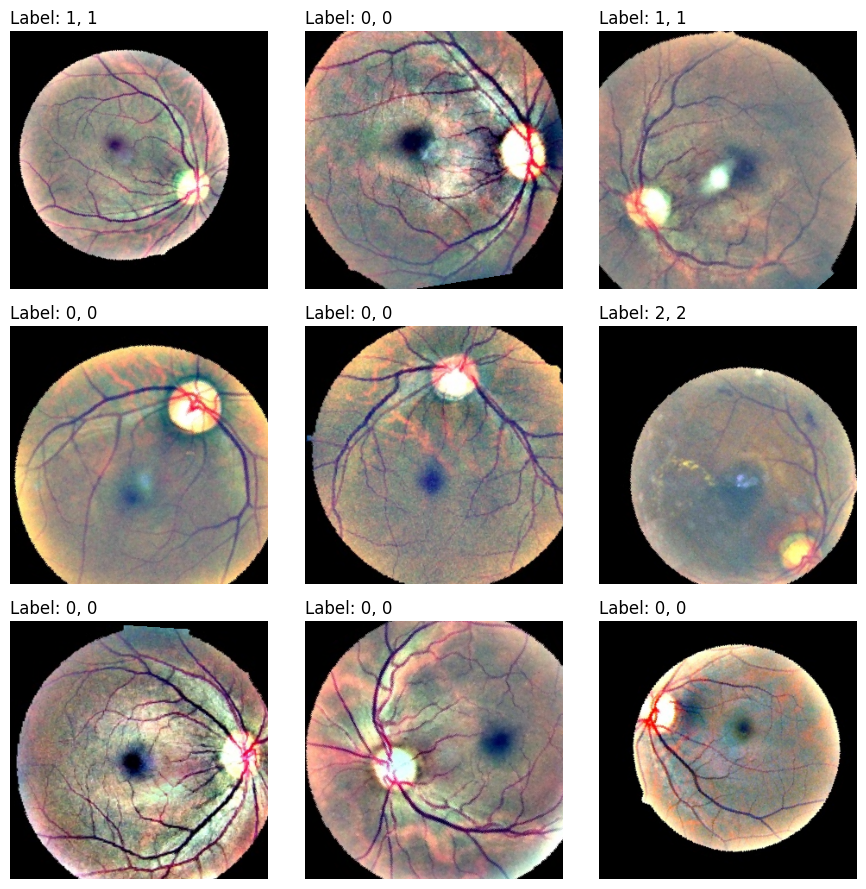

In [8]:
visualise_img(ben_train_dataloader, ben_train_dataset.classes)

Images batch shape: torch.Size([64, 3, 299, 299])
Labels batch shape: torch.Size([64])


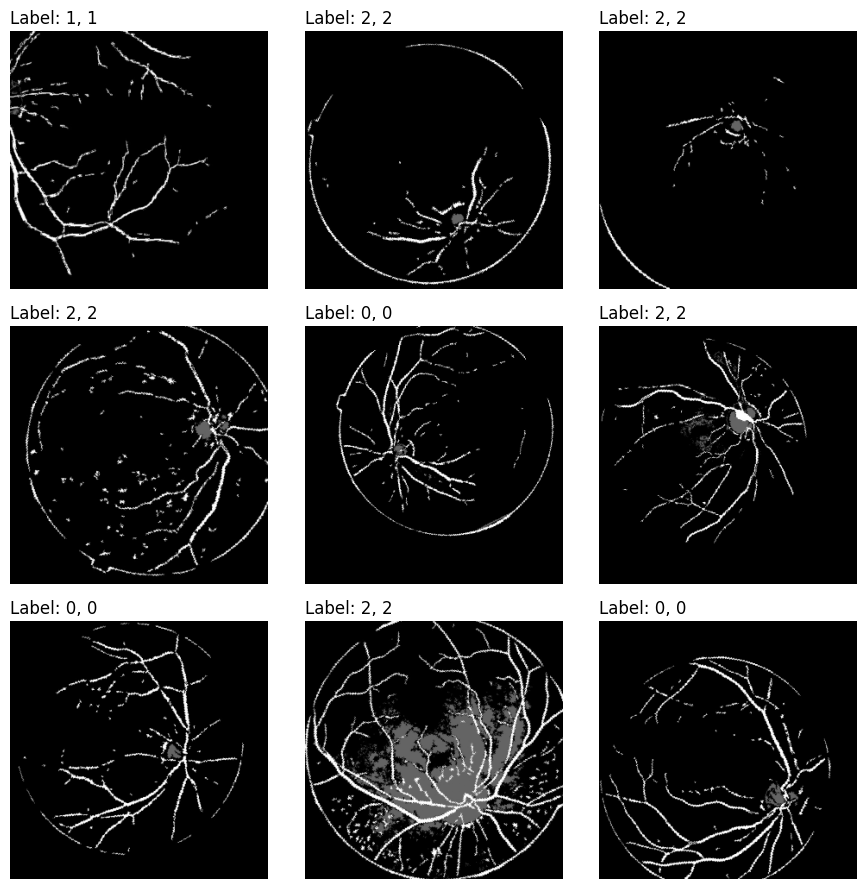

In [9]:
visualise_img(clahe_train_dataloader, clahe_train_dataset.classes)

Images batch shape: torch.Size([64, 3, 299, 299])
Labels batch shape: torch.Size([64])


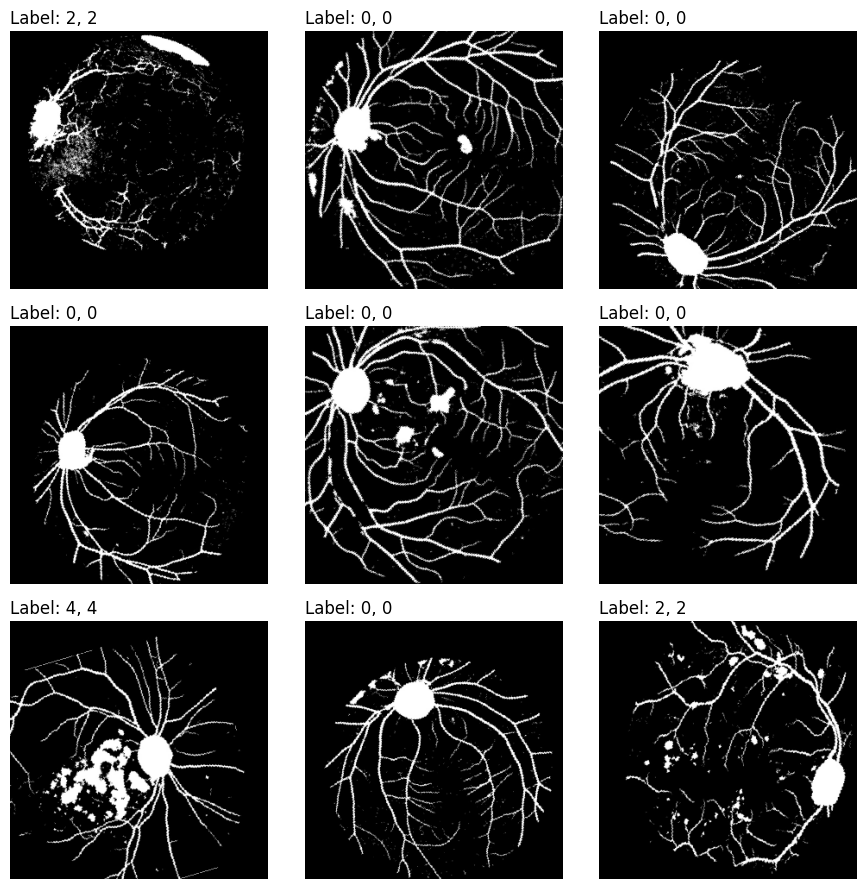

In [10]:
visualise_img(unetb_train_dataloader, unetb_train_dataset.classes)

Images batch shape: torch.Size([64, 3, 299, 299])
Labels batch shape: torch.Size([64])


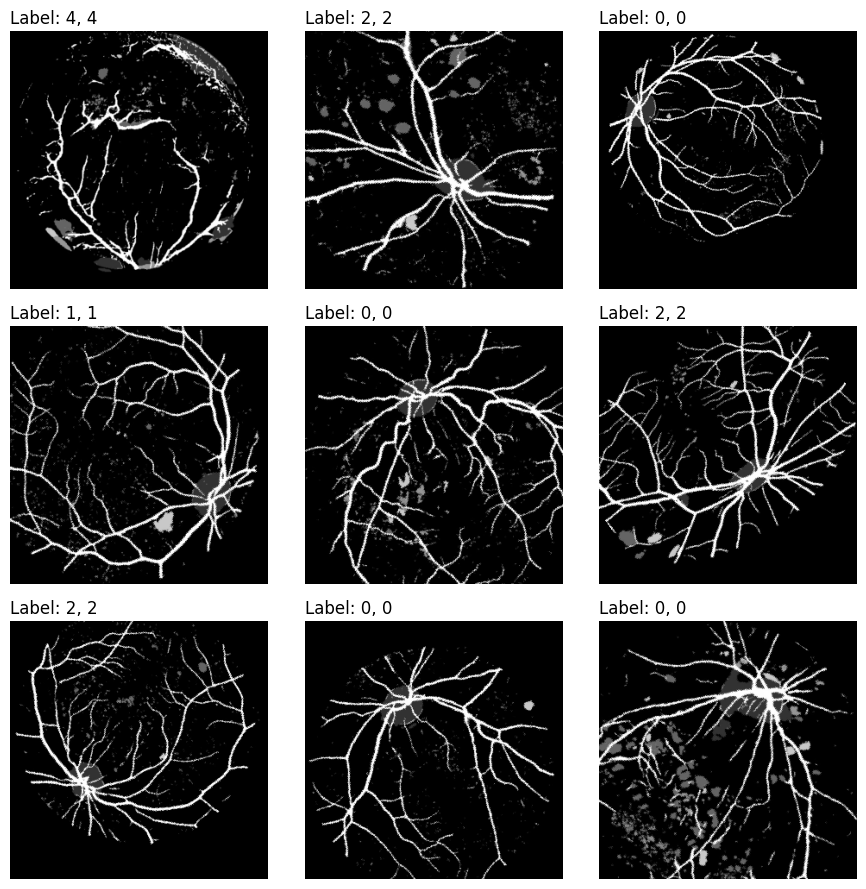

In [11]:
visualise_img(unetm_train_dataloader, unetm_train_dataset.classes)

### Train, Eval Functions

In [12]:
import torch

def eval(model, 
         criterion, 
         img_size:tuple,
         val_dataloader, 
         device='cuda'):
    """
    Evaluation function for finetuning CNN models with a model object,
    incorporating average sensitivity for a multiclass problem.

    Sensitivity function: True Positives / (True Positives + False Negatives)

    Args:
        model: model to be trained
        criterion: loss function
        img_size (tuple): image size of dataset for model. All inputs will be resized to image size
        val_dataloader: val / test dataloader
        device (str, optional): 'cpu' or 'cuda', defaults to cuda.

    Returns:
        val_loss: float of the average val loss.
        val_accuracy: float of the accuracy.
        val_sensitivity: float of the average sensitivity across all classes.
    """

    model = model.to(device)
    
    #set model to eval mode
    model.eval()

    #variables 
    val_loss = 0.0
    correct = 0
    total = 0
    n_classes = 5
    true_positives = [0] * n_classes #stores num of true positives per class
    actual_positives = [0] * n_classes #stores total number of positives per class
    total_sensitivity = 0

    with torch.no_grad():
        for image, label in val_dataloader:
            batch_sensitivity = 0

            #resize image with bilinear, same as torchvision.transforms.Resize()
            image = torch.nn.functional.interpolate(image, size=img_size, mode='bilinear') 
            image, label = image.to(device), label.to(device)

            outputs = model(image)  #predict label
            loss = criterion(outputs, label)  #calculate loss
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1) #get prediction
            total += label.size(0)
            correct += (predicted == label).sum().item()

            for i in range(n_classes):
                true_positives[i] += ((predicted == i) & (label == i)).sum().item() #true positives
                actual_positives[i] += (label == i).sum().item() #true positives + false negatives
            
                if (label == i).sum().item() > 0:
                    batch_sensitivity += true_positives[i] / actual_positives[i]

                else:
                    pass
            
            total_sensitivity += batch_sensitivity/n_classes #average sensitivity for batch

    # Calculate accuracy, avg loss, and avg sensitivity
    accuracy = (correct / total) * 100
    avg_val_loss = val_loss / len(val_dataloader)
    avg_sensitivity = total_sensitivity/len(val_dataloader)
    
    return avg_val_loss, accuracy, avg_sensitivity


In [13]:
def train(model, 
          criterion, 
          optimiser, 
          img_size:tuple,
          train_dataloader, 
          val_dataloader=None, 
          saving_metric:str='sensitivity',
          num_epochs:int=25, 
          device:str='cuda', 
          model_name:str=None):
    """
    Training Function to train model
    Runs validation for each epoch to calculate: Validation Loss, Validation Accuracy, Validation Sensitivity
    Best and last model will be saved to ../models/cnn under {model_name}_best.pt and {model_name}_last.pt
    
    Args:
        model: model to be trained
        criterion: loss function
        optimiser: optimiser chosen
        img_size (tuple): image size of dataset for model. All inputs will be resized to image size
        train_dataloader: train dataloader
        val_dataloader (optional): val dataloader, if None no validation will be calculated. Defaults to None.
        saving_metric (str, optional): saving metrics for best model, either "loss", "accuracy", or "sensitivity". Defaults to 'sensitivity'.
        num_epochs (int, optional): number of training epochs. Defaults to 25.
        device (str, optional): cuda or cpu. Defaults to 'cuda'.
        model_name (str, optional): model name to be saved, if None no model will be saved. Defaults to None.

    Returns:
        results_dataframe: dataframe of [model, train_loss, val_loss, val_accuracy, val_sensitivity] where each row is each epoch
    """

    if saving_metric not in ["loss", "accuracy", "sensitivity"]:
        raise Exception("Invalid saving metrics found, please only use loss, accuracy or sensitivity")

    #initialising results container
    results = pd.DataFrame(columns=["Model", "train loss", "val loss", "val accuracy", "val sensitivity"])
    
    #placeholders
    val_loss = ''
    val_accuracy = ''
    val_sensitivity = ''


    for epoch in range(num_epochs):

        #initialising training
        model.train()
        training_loss = 0.0

        for image, label in tqdm(train_dataloader):
            
            #resize image with bilinear, same as torchvision.transforms.Resize()
            image = torch.nn.functional.interpolate(image, size=img_size, mode='bilinear') 
            image, label = image.to(device), label.to(device)

            optimiser.zero_grad()
            outputs = model(image)
            #calculate loss and train model
            loss = criterion(outputs, label)
            loss.backward()
            optimiser.step()
            training_loss += loss.item() #update the training loss

        epoch_loss = training_loss / len(train_dataloader) #calculate training loss in epoch
        print(f"Epoch {epoch+1} completed, training loss: {epoch_loss}")

        #validation
        if val_dataloader is not None:
            model.eval()  #set model to evaluate mode
            val_loss, val_accuracy,  val_sensitivity = eval(model=model, 
                                                               criterion=criterion,
                                                                val_dataloader=val_dataloader, 
                                                                img_size = img_size,
                                                                device=device) 
            
            print(f"Validation loss: {val_loss}, Validation Accuracy: {val_accuracy:.2f}, Validation Sensitivty: {val_sensitivity:2f}")
            

            if saving_metric == 'loss' and len(results) > 0 and val_loss < min(results['val loss'].to_list()):
                torch.save(model, f'../models/cnn/{model_name}_best.pt')
                print("Best model saved")

            elif saving_metric == 'accuracy' and len(results) > 0 and val_accuracy > max(results['val accuracy'].to_list()):
                torch.save(model, f'../models/cnn/{model_name}_best.pt')
                print("Best model saved")

            elif saving_metric == 'sensitivity' and len(results) > 0 and val_sensitivity > max(results['val sensitivity'].to_list()):
                torch.save(model, f'../models/cnn/{model_name}_best.pt')
                print("Best model saved")
            
        #updating results
        results.loc[len(results)] = [model_name, epoch_loss, val_loss, val_accuracy, val_sensitivity]


    #save the last model
    if model_name is not None:
        torch.save(model, f'../models/cnn/{model_name}_last.pt')

    return results


### Model

In [14]:
class PreTrainedCNNModels(torch.nn.Module):
    def __init__(self, model_type:str, num_unfreeze:int, num_class:int):
        super(PreTrainedCNNModels, self).__init__()
        """
        Class that contains InceptionV3, Resnet50, Resnet152, EfficientNet, DenseNet, VGG16, MaxVit fine tuned models

        Args:
            model_type (str): Determines which pre-trained models to use
                              Must be: InceptionV3, Resnet50, Resnet152, EfficientNet, DenseNet, VGG16, MaxVit
            num_unfreeze (int): Number of layers to unfreeze and finetune
            num_class (int): Number of output classes for the classification
        """
        #selecting model type
        if model_type == 'InceptionV3':
            self.model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
            self.model.aux_logits = False

        elif model_type == 'Resnet50':
            self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        elif model_type == 'Resnet152':
            self.model = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)

        elif model_type == 'EfficientNet':
            self.model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)

        elif model_type == 'DenseNet':
            self.model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        
        elif model_type == 'VGG16':
            self.model = models.vgg16_bn(weights=models.VGG16_BN_Weights.DEFAULT)

        elif model_type == 'MaxVit':
            self.model = models.maxvit_t(weights=models.MaxVit_T_Weights.DEFAULT)
        
        else:
            raise Exception("Invalid model type chosen. Please select one of the following\n[InceptionV3, Resnet50, Resnet152, EfficientNet, DenseNet, VGG16, MaxVit]")

        
        #modifying final layer
        if model_type in ['InceptionV3', 'Resnet50', 'Resnet152']:
            self.model.fc = torch.nn.Linear(self.model.fc.in_features, num_class)

        elif model_type == 'DenseNet':
            self.model.classifier = torch.nn.Linear(self.model.classifier.in_features, num_class)

        else:
            self.model.classifier[-1] = torch.nn.Linear(self.model.classifier[-1].in_features, num_class)


        model_paramteres = list(self.model.parameters())
        #unfreeze last num_unfreeze layers
        for param in model_paramteres[-num_unfreeze:]:
            param.requires_grad = True

        #freeze rest of the layers
        for param in model_paramteres[:-num_unfreeze]:
            param.requires_grad = False


    def forward(self, images):
        return self.model(images)

### Training all model with weighted(custom) class

Training all model with Cross Entropy Loss with any class weights on Ben Graham dataset

In [15]:
models_list = [['InceptionV3', (299,299)],
               ['Resnet50', (224,224)],
               ['Resnet152',(224,224)],
               ['EfficientNet',(224,224)],
               ['DenseNet',(224,224)],
               ['VGG16',(224,224)],
               ['MaxVit', (224,224)]]


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 30
layers = [4,16,32]
all_results = pd.DataFrame(columns=["Model", "train loss", "val loss", "val accuracy", "val sensitivity"])

for layer in layers:
    model_name="Resnet152"
    img_size = (224,224)
    #clear cuda memory
    torch.cuda.empty_cache()
    gc.collect()

    model = PreTrainedCNNModels(model_name, layer, len(ben_train_dataset.classes)).to(device)
    criterion=torch.nn.CrossEntropyLoss(weight=torch.tensor([1, 6, 1, 10, 3], dtype=torch.float32).to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

    print(f"-------------Training {model_name}_{layer}------------")
    model_result = train(model,
                         criterion,
                         optimizer,
                         img_size,
                         ben_train_dataloader,
                         ben_val_dataloader,
                         'sensitivity',
                         num_epochs,
                         device,
                         f"{model_name}_{layer}")
    
    all_results =  pd.concat([all_results, model_result])

all_results.to_csv("results/resnet152_layers.csv")


-------------Training Resnet152_4------------


100%|██████████| 137/137 [00:44<00:00,  3.08it/s]


Epoch 1 completed, training loss: 1.426431247787754
Validation loss: 1.3028141458829243, Validation Accuracy: 62.64, Validation Sensitivty: 0.374997


100%|██████████| 137/137 [00:39<00:00,  3.44it/s]


Epoch 2 completed, training loss: 1.2870559561861692
Validation loss: 1.2354673186937968, Validation Accuracy: 64.13, Validation Sensitivty: 0.382389
Best model saved


100%|██████████| 137/137 [00:39<00:00,  3.48it/s]


Epoch 3 completed, training loss: 1.2281454927729865
Validation loss: 1.1908817728360495, Validation Accuracy: 66.68, Validation Sensitivty: 0.401511
Best model saved


100%|██████████| 137/137 [00:39<00:00,  3.48it/s]


Epoch 4 completed, training loss: 1.1911736726760864
Validation loss: 1.1720812996228536, Validation Accuracy: 65.62, Validation Sensitivty: 0.402058
Best model saved


100%|██████████| 137/137 [00:39<00:00,  3.48it/s]


Epoch 5 completed, training loss: 1.1527482166777563
Validation loss: 1.1357184946537018, Validation Accuracy: 65.78, Validation Sensitivty: 0.402485
Best model saved


100%|██████████| 137/137 [00:39<00:00,  3.46it/s]


Epoch 6 completed, training loss: 1.130912983504525
Validation loss: 1.1262458006540934, Validation Accuracy: 62.96, Validation Sensitivty: 0.419190
Best model saved


100%|██████████| 137/137 [00:39<00:00,  3.48it/s]


Epoch 7 completed, training loss: 1.1122205731642507
Validation loss: 1.1037947396437326, Validation Accuracy: 64.08, Validation Sensitivty: 0.433904
Best model saved


100%|██████████| 137/137 [00:39<00:00,  3.51it/s]


Epoch 8 completed, training loss: 1.098503584409282
Validation loss: 1.0964604218800862, Validation Accuracy: 64.93, Validation Sensitivty: 0.404403


100%|██████████| 137/137 [00:39<00:00,  3.50it/s]


Epoch 9 completed, training loss: 1.0741609156566814
Validation loss: 1.088974952697754, Validation Accuracy: 63.97, Validation Sensitivty: 0.448253
Best model saved


100%|██████████| 137/137 [00:39<00:00,  3.48it/s]


Epoch 10 completed, training loss: 1.0775728425840392
Validation loss: 1.0789545714855193, Validation Accuracy: 65.03, Validation Sensitivty: 0.465244
Best model saved


100%|██████████| 137/137 [00:39<00:00,  3.45it/s]


Epoch 11 completed, training loss: 1.0660169842469431
Validation loss: 1.0802919526894887, Validation Accuracy: 62.48, Validation Sensitivty: 0.453610


100%|██████████| 137/137 [00:39<00:00,  3.45it/s]


Epoch 12 completed, training loss: 1.054245568975045
Validation loss: 1.0683342158794402, Validation Accuracy: 66.90, Validation Sensitivty: 0.469812
Best model saved


100%|██████████| 137/137 [00:39<00:00,  3.47it/s]


Epoch 13 completed, training loss: 1.044345096515043
Validation loss: 1.0571080207824708, Validation Accuracy: 63.97, Validation Sensitivty: 0.440381


100%|██████████| 137/137 [00:39<00:00,  3.46it/s]


Epoch 14 completed, training loss: 1.039201685982029
Validation loss: 1.0644580145676932, Validation Accuracy: 64.45, Validation Sensitivty: 0.493780
Best model saved


100%|██████████| 137/137 [00:39<00:00,  3.46it/s]


Epoch 15 completed, training loss: 1.0332731008529663
Validation loss: 1.0632167637348175, Validation Accuracy: 64.18, Validation Sensitivty: 0.479174


100%|██████████| 137/137 [00:39<00:00,  3.48it/s]


Epoch 16 completed, training loss: 1.0246171094205259
Validation loss: 1.0545290450255076, Validation Accuracy: 65.83, Validation Sensitivty: 0.435981


100%|██████████| 137/137 [00:39<00:00,  3.50it/s]


Epoch 17 completed, training loss: 1.0208140489828847
Validation loss: 1.0586342851320902, Validation Accuracy: 64.98, Validation Sensitivty: 0.452565


100%|██████████| 137/137 [00:39<00:00,  3.48it/s]


Epoch 18 completed, training loss: 1.020287214404475
Validation loss: 1.050614857673645, Validation Accuracy: 63.76, Validation Sensitivty: 0.444983


100%|██████████| 137/137 [00:39<00:00,  3.43it/s]


Epoch 19 completed, training loss: 1.004597348888425
Validation loss: 1.083602738380432, Validation Accuracy: 68.49, Validation Sensitivty: 0.462632


100%|██████████| 137/137 [00:42<00:00,  3.26it/s]


Epoch 20 completed, training loss: 1.0049282973700195
Validation loss: 1.044598678747813, Validation Accuracy: 66.10, Validation Sensitivty: 0.438100


100%|██████████| 137/137 [00:39<00:00,  3.50it/s]


Epoch 21 completed, training loss: 1.0010125867641755
Validation loss: 1.0404472966988882, Validation Accuracy: 66.05, Validation Sensitivty: 0.447522


100%|██████████| 137/137 [00:38<00:00,  3.54it/s]


Epoch 22 completed, training loss: 1.0074761074824925
Validation loss: 1.0460961202780406, Validation Accuracy: 64.61, Validation Sensitivty: 0.470860


100%|██████████| 137/137 [00:44<00:00,  3.09it/s]


Epoch 23 completed, training loss: 1.000030397933765
Validation loss: 1.0220928649107615, Validation Accuracy: 64.34, Validation Sensitivty: 0.472807


100%|██████████| 137/137 [00:44<00:00,  3.05it/s]


Epoch 24 completed, training loss: 0.9859770292783305
Validation loss: 1.0319260915120443, Validation Accuracy: 63.86, Validation Sensitivty: 0.491319


100%|██████████| 137/137 [00:41<00:00,  3.29it/s]


Epoch 25 completed, training loss: 0.988304015493741
Validation loss: 1.0420496046543122, Validation Accuracy: 62.05, Validation Sensitivty: 0.477848


100%|██████████| 137/137 [00:40<00:00,  3.37it/s]


Epoch 26 completed, training loss: 0.9819261101040527
Validation loss: 1.042172416051229, Validation Accuracy: 63.54, Validation Sensitivty: 0.485142


100%|██████████| 137/137 [00:40<00:00,  3.36it/s]


Epoch 27 completed, training loss: 0.9743012324736936
Validation loss: 1.0400641500949859, Validation Accuracy: 65.35, Validation Sensitivty: 0.463209


100%|██████████| 137/137 [00:41<00:00,  3.31it/s]


Epoch 28 completed, training loss: 0.9699248271266909
Validation loss: 1.0478740255037944, Validation Accuracy: 65.57, Validation Sensitivty: 0.469092


100%|██████████| 137/137 [00:40<00:00,  3.35it/s]


Epoch 29 completed, training loss: 0.9845272981337387
Validation loss: 1.0442755699157715, Validation Accuracy: 64.56, Validation Sensitivty: 0.490138


100%|██████████| 137/137 [00:41<00:00,  3.33it/s]


Epoch 30 completed, training loss: 0.980369512617153
Validation loss: 1.0406537195046743, Validation Accuracy: 62.75, Validation Sensitivty: 0.496559
Best model saved
-------------Training Resnet152_16------------


100%|██████████| 137/137 [00:42<00:00,  3.19it/s]


Epoch 1 completed, training loss: 1.2812987996713958
Validation loss: 1.090031812588374, Validation Accuracy: 61.63, Validation Sensitivty: 0.469260


100%|██████████| 137/137 [00:42<00:00,  3.24it/s]


Epoch 2 completed, training loss: 1.07874701667006
Validation loss: 1.01632515390714, Validation Accuracy: 61.42, Validation Sensitivty: 0.508921
Best model saved


100%|██████████| 137/137 [00:42<00:00,  3.24it/s]


Epoch 3 completed, training loss: 1.0086280181460137
Validation loss: 1.1073728462060293, Validation Accuracy: 64.45, Validation Sensitivty: 0.427005


100%|██████████| 137/137 [00:42<00:00,  3.22it/s]


Epoch 4 completed, training loss: 0.971584986596212
Validation loss: 1.0061875800291697, Validation Accuracy: 64.34, Validation Sensitivty: 0.467854


100%|██████████| 137/137 [00:42<00:00,  3.23it/s]


Epoch 5 completed, training loss: 0.9116751851826689
Validation loss: 1.014208940664927, Validation Accuracy: 59.98, Validation Sensitivty: 0.485011


100%|██████████| 137/137 [00:42<00:00,  3.25it/s]


Epoch 6 completed, training loss: 0.8837889280632465
Validation loss: 1.073204650481542, Validation Accuracy: 70.30, Validation Sensitivty: 0.494961


100%|██████████| 137/137 [00:42<00:00,  3.23it/s]


Epoch 7 completed, training loss: 0.8840199695886487
Validation loss: 1.0675180514653524, Validation Accuracy: 67.64, Validation Sensitivty: 0.502500


100%|██████████| 137/137 [00:42<00:00,  3.25it/s]


Epoch 8 completed, training loss: 0.84627663132048
Validation loss: 1.0285953283309937, Validation Accuracy: 66.74, Validation Sensitivty: 0.495229


100%|██████████| 137/137 [00:42<00:00,  3.26it/s]


Epoch 9 completed, training loss: 0.8298540811469085
Validation loss: 1.0266014556090037, Validation Accuracy: 69.29, Validation Sensitivty: 0.505989


100%|██████████| 137/137 [00:42<00:00,  3.24it/s]


Epoch 10 completed, training loss: 0.8046272701590601
Validation loss: 1.0430373966693878, Validation Accuracy: 63.60, Validation Sensitivty: 0.518386
Best model saved


100%|██████████| 137/137 [00:41<00:00,  3.27it/s]


Epoch 11 completed, training loss: 0.7715401908341986
Validation loss: 1.0408438821633657, Validation Accuracy: 68.44, Validation Sensitivty: 0.456933


100%|██████████| 137/137 [00:42<00:00,  3.24it/s]


Epoch 12 completed, training loss: 0.7507257557263339
Validation loss: 1.04559375445048, Validation Accuracy: 66.79, Validation Sensitivty: 0.547365
Best model saved


100%|██████████| 137/137 [00:42<00:00,  3.22it/s]


Epoch 13 completed, training loss: 0.734976674518446
Validation loss: 1.193005226055781, Validation Accuracy: 70.09, Validation Sensitivty: 0.473894


100%|██████████| 137/137 [00:44<00:00,  3.09it/s]


Epoch 14 completed, training loss: 0.7174987690727206
Validation loss: 1.1083065211772918, Validation Accuracy: 69.56, Validation Sensitivty: 0.522514


100%|██████████| 137/137 [00:43<00:00,  3.13it/s]


Epoch 15 completed, training loss: 0.728294458702533
Validation loss: 1.0955331345399222, Validation Accuracy: 63.38, Validation Sensitivty: 0.541046


100%|██████████| 137/137 [00:44<00:00,  3.05it/s]


Epoch 16 completed, training loss: 0.7045898794257728
Validation loss: 1.2277333875497183, Validation Accuracy: 70.36, Validation Sensitivty: 0.463865


100%|██████████| 137/137 [00:45<00:00,  3.04it/s]


Epoch 17 completed, training loss: 0.6981202677218583
Validation loss: 1.1957234700520833, Validation Accuracy: 69.08, Validation Sensitivty: 0.460549


100%|██████████| 137/137 [00:44<00:00,  3.11it/s]


Epoch 18 completed, training loss: 0.6785046891139371
Validation loss: 1.1899178475141525, Validation Accuracy: 68.65, Validation Sensitivty: 0.499898


100%|██████████| 137/137 [00:44<00:00,  3.07it/s]


Epoch 19 completed, training loss: 0.6710898897943706
Validation loss: 1.1288696517546972, Validation Accuracy: 69.56, Validation Sensitivty: 0.472997


100%|██████████| 137/137 [00:44<00:00,  3.06it/s]


Epoch 20 completed, training loss: 0.6465775183517567
Validation loss: 1.220468478401502, Validation Accuracy: 69.40, Validation Sensitivty: 0.487712


100%|██████████| 137/137 [00:45<00:00,  3.04it/s]


Epoch 21 completed, training loss: 0.6267984107027958
Validation loss: 1.300185892979304, Validation Accuracy: 63.97, Validation Sensitivty: 0.530805


100%|██████████| 137/137 [00:44<00:00,  3.07it/s]


Epoch 22 completed, training loss: 0.6226371320059699
Validation loss: 1.2312024891376496, Validation Accuracy: 68.39, Validation Sensitivty: 0.510379


100%|██████████| 137/137 [00:44<00:00,  3.05it/s]


Epoch 23 completed, training loss: 0.6275262188737409
Validation loss: 1.2363225569327672, Validation Accuracy: 69.56, Validation Sensitivty: 0.531724


100%|██████████| 137/137 [00:43<00:00,  3.14it/s]


Epoch 24 completed, training loss: 0.5942974717077547
Validation loss: 1.324834841489792, Validation Accuracy: 69.19, Validation Sensitivty: 0.523980


100%|██████████| 137/137 [00:44<00:00,  3.11it/s]


Epoch 25 completed, training loss: 0.587304979127689
Validation loss: 1.3471935550371805, Validation Accuracy: 72.33, Validation Sensitivty: 0.488518


100%|██████████| 137/137 [00:45<00:00,  3.01it/s]


Epoch 26 completed, training loss: 0.5587120297616416
Validation loss: 1.32565748890241, Validation Accuracy: 70.84, Validation Sensitivty: 0.504197


100%|██████████| 137/137 [00:44<00:00,  3.07it/s]


Epoch 27 completed, training loss: 0.5735944526909041
Validation loss: 1.281436425447464, Validation Accuracy: 69.29, Validation Sensitivty: 0.486970


100%|██████████| 137/137 [00:47<00:00,  2.90it/s]


Epoch 28 completed, training loss: 0.5730394812395972
Validation loss: 1.188811973730723, Validation Accuracy: 67.96, Validation Sensitivty: 0.513525


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 29 completed, training loss: 0.5607489980485317
Validation loss: 1.2603685994942984, Validation Accuracy: 71.31, Validation Sensitivty: 0.504832


100%|██████████| 137/137 [00:46<00:00,  2.92it/s]


Epoch 30 completed, training loss: 0.5374421383777674
Validation loss: 1.3479357004165649, Validation Accuracy: 70.14, Validation Sensitivty: 0.516876
-------------Training Resnet152_32------------


100%|██████████| 137/137 [00:51<00:00,  2.67it/s]


Epoch 1 completed, training loss: 1.142199608096241
Validation loss: 1.015643843015035, Validation Accuracy: 67.43, Validation Sensitivty: 0.501859


100%|██████████| 137/137 [00:50<00:00,  2.73it/s]


Epoch 2 completed, training loss: 0.9219078064834985
Validation loss: 0.9608055591583252, Validation Accuracy: 69.51, Validation Sensitivty: 0.514443
Best model saved


100%|██████████| 137/137 [00:47<00:00,  2.86it/s]


Epoch 3 completed, training loss: 0.8430543876912472
Validation loss: 0.9820906798044841, Validation Accuracy: 67.32, Validation Sensitivty: 0.533995
Best model saved


100%|██████████| 137/137 [00:48<00:00,  2.83it/s]


Epoch 4 completed, training loss: 0.7891797023097964
Validation loss: 1.0375357697407404, Validation Accuracy: 69.51, Validation Sensitivty: 0.516649


100%|██████████| 137/137 [00:46<00:00,  2.98it/s]


Epoch 5 completed, training loss: 0.7448001912910572
Validation loss: 1.0364261905352274, Validation Accuracy: 72.70, Validation Sensitivty: 0.497039


100%|██████████| 137/137 [00:46<00:00,  2.98it/s]


Epoch 6 completed, training loss: 0.6910063907177779
Validation loss: 0.9349738279978435, Validation Accuracy: 71.26, Validation Sensitivty: 0.552813
Best model saved


100%|██████████| 137/137 [00:45<00:00,  3.03it/s]


Epoch 7 completed, training loss: 0.6547914786930502
Validation loss: 1.014524789651235, Validation Accuracy: 69.93, Validation Sensitivty: 0.530936


100%|██████████| 137/137 [00:43<00:00,  3.15it/s]


Epoch 8 completed, training loss: 0.6332329315860776
Validation loss: 1.040375328063965, Validation Accuracy: 69.72, Validation Sensitivty: 0.555683
Best model saved


100%|██████████| 137/137 [00:44<00:00,  3.11it/s]


Epoch 9 completed, training loss: 0.6029548462289963
Validation loss: 1.1312488675117494, Validation Accuracy: 68.01, Validation Sensitivty: 0.533940


100%|██████████| 137/137 [00:43<00:00,  3.13it/s]


Epoch 10 completed, training loss: 0.5964634877486821
Validation loss: 1.1405891120433806, Validation Accuracy: 70.57, Validation Sensitivty: 0.530503


100%|██████████| 137/137 [00:43<00:00,  3.13it/s]


Epoch 11 completed, training loss: 0.5392589771399533
Validation loss: 1.159805624683698, Validation Accuracy: 68.49, Validation Sensitivty: 0.564178
Best model saved


100%|██████████| 137/137 [00:43<00:00,  3.16it/s]


Epoch 12 completed, training loss: 0.5184231931275695
Validation loss: 1.1634520232677459, Validation Accuracy: 72.06, Validation Sensitivty: 0.547798


100%|██████████| 137/137 [00:42<00:00,  3.19it/s]


Epoch 13 completed, training loss: 0.501762696752583
Validation loss: 1.3293568462133407, Validation Accuracy: 72.65, Validation Sensitivty: 0.568932
Best model saved


100%|██████████| 137/137 [00:40<00:00,  3.39it/s]


Epoch 14 completed, training loss: 0.4946202042981656
Validation loss: 1.2413892169793448, Validation Accuracy: 70.09, Validation Sensitivty: 0.515402


100%|██████████| 137/137 [00:40<00:00,  3.35it/s]


Epoch 15 completed, training loss: 0.45689061044776524
Validation loss: 1.2925255010525385, Validation Accuracy: 72.06, Validation Sensitivty: 0.518038


100%|██████████| 137/137 [00:40<00:00,  3.39it/s]


Epoch 16 completed, training loss: 0.456298358031433
Validation loss: 1.229365211725235, Validation Accuracy: 73.18, Validation Sensitivty: 0.551138


100%|██████████| 137/137 [00:39<00:00,  3.47it/s]


Epoch 17 completed, training loss: 0.42962640567417565
Validation loss: 1.28225949605306, Validation Accuracy: 69.88, Validation Sensitivty: 0.542098


100%|██████████| 137/137 [00:39<00:00,  3.46it/s]


Epoch 18 completed, training loss: 0.4172583209337109
Validation loss: 1.229658834139506, Validation Accuracy: 75.09, Validation Sensitivty: 0.565734


100%|██████████| 137/137 [00:40<00:00,  3.38it/s]


Epoch 19 completed, training loss: 0.3918340460662424
Validation loss: 1.5583525369564692, Validation Accuracy: 74.56, Validation Sensitivty: 0.525335


100%|██████████| 137/137 [00:40<00:00,  3.35it/s]


Epoch 20 completed, training loss: 0.4028322448695663
Validation loss: 1.3264747122923533, Validation Accuracy: 75.57, Validation Sensitivty: 0.557077


100%|██████████| 137/137 [00:40<00:00,  3.35it/s]


Epoch 21 completed, training loss: 0.3675905505236048
Validation loss: 1.53002940316995, Validation Accuracy: 75.73, Validation Sensitivty: 0.503724


100%|██████████| 137/137 [00:39<00:00,  3.46it/s]


Epoch 22 completed, training loss: 0.364850292023081
Validation loss: 1.5119661390781403, Validation Accuracy: 77.33, Validation Sensitivty: 0.559684


100%|██████████| 137/137 [00:40<00:00,  3.41it/s]


Epoch 23 completed, training loss: 0.35484502437340953
Validation loss: 1.473716738820076, Validation Accuracy: 73.60, Validation Sensitivty: 0.543161


100%|██████████| 137/137 [00:40<00:00,  3.36it/s]


Epoch 24 completed, training loss: 0.3412865059871743
Validation loss: 1.4060189753770829, Validation Accuracy: 75.73, Validation Sensitivty: 0.566613


100%|██████████| 137/137 [00:39<00:00,  3.46it/s]


Epoch 25 completed, training loss: 0.3248459709277988
Validation loss: 1.6053743918736776, Validation Accuracy: 76.48, Validation Sensitivty: 0.570942
Best model saved


100%|██████████| 137/137 [00:39<00:00,  3.48it/s]


Epoch 26 completed, training loss: 0.310092513469884
Validation loss: 1.3979200184345246, Validation Accuracy: 74.56, Validation Sensitivty: 0.544021


100%|██████████| 137/137 [00:40<00:00,  3.40it/s]


Epoch 27 completed, training loss: 0.30437758956512395
Validation loss: 1.472237116098404, Validation Accuracy: 75.57, Validation Sensitivty: 0.519728


100%|██████████| 137/137 [00:40<00:00,  3.38it/s]


Epoch 28 completed, training loss: 0.2977793746403534
Validation loss: 1.6871689538160959, Validation Accuracy: 76.05, Validation Sensitivty: 0.549508


100%|██████████| 137/137 [00:40<00:00,  3.38it/s]


Epoch 29 completed, training loss: 0.31108278079624596
Validation loss: 1.4529156704743704, Validation Accuracy: 74.40, Validation Sensitivty: 0.569106


100%|██████████| 137/137 [00:40<00:00,  3.37it/s]


Epoch 30 completed, training loss: 0.28064214867832016
Validation loss: 1.5302192270755768, Validation Accuracy: 73.87, Validation Sensitivty: 0.525445


In [18]:
models_list = [['InceptionV3', (299,299)],
               ['Resnet50', (224,224)],
               ['Resnet152',(224,224)],
               ['EfficientNet',(224,224)],
               ['DenseNet',(224,224)],
               ['VGG16',(224,224)],
               ['MaxVit', (224,224)]]


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for layer in layers:
    model_name="Resnet152"

    #clear cuda memory
    torch.cuda.empty_cache()
    gc.collect()

    best_model = torch.load(f'../models/cnn/{model_name}_{layer}_best.pt')
    last_model = torch.load(f'../models/cnn/{model_name}_{layer}_last.pt')
    criterion=torch.nn.CrossEntropyLoss()

    print(f"-------------Evluating {model_name}_{layer}------------")
    loss, accuracy, sensitivity = eval(best_model,
                                        criterion,
                                        img_size,
                                        ben_test_dataloader,
                                        device)
    print(f"Best Model - Test Loss: {loss}, Test Accuracy: {accuracy}, Test Sensitivity: {sensitivity}")
    loss, accuracy, sensitivity = eval(last_model,
                                        criterion,
                                        img_size,
                                        ben_test_dataloader,
                                        device)
    print(f"Last Model - Test Loss: {loss}, Test Accuracy: {accuracy}, Test Sensitivity: {sensitivity}")

-------------Evluating Resnet152_4------------
Best Model - Test Loss: 1.129262626171112, Test Accuracy: 56.78552421500799, Test Sensitivity: 0.49723905077997127
Last Model - Test Loss: 1.1344627698262533, Test Accuracy: 56.78552421500799, Test Sensitivity: 0.5265206598219143
-------------Evluating Resnet152_16------------
Best Model - Test Loss: 0.9513079881668091, Test Accuracy: 61.788185204896216, Test Sensitivity: 0.545585170820853
Last Model - Test Loss: 0.9669143219788869, Test Accuracy: 62.10750399148483, Test Sensitivity: 0.54140258314386
-------------Evluating Resnet152_32------------
Best Model - Test Loss: 0.6352423340082168, Test Accuracy: 76.74294837679618, Test Sensitivity: 0.5259628374760476
Last Model - Test Loss: 0.7062874337037405, Test Accuracy: 73.23044172432145, Test Sensitivity: 0.5546470454431229


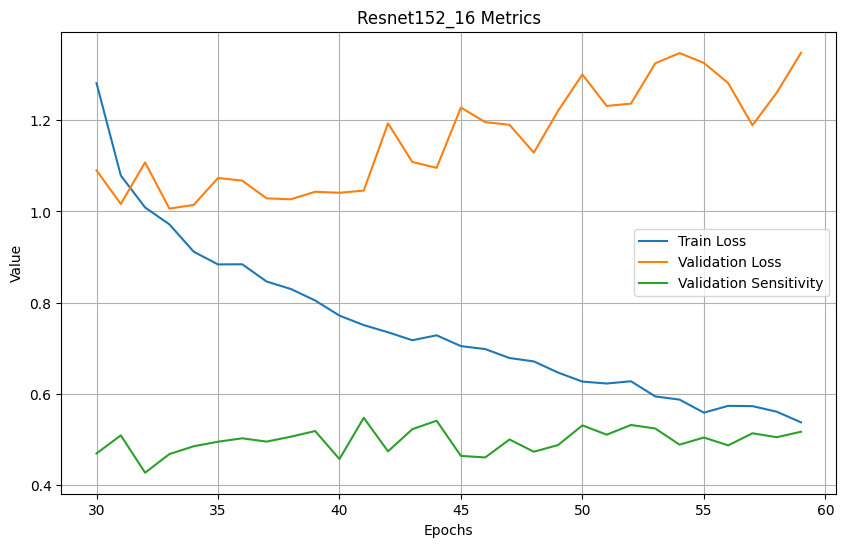

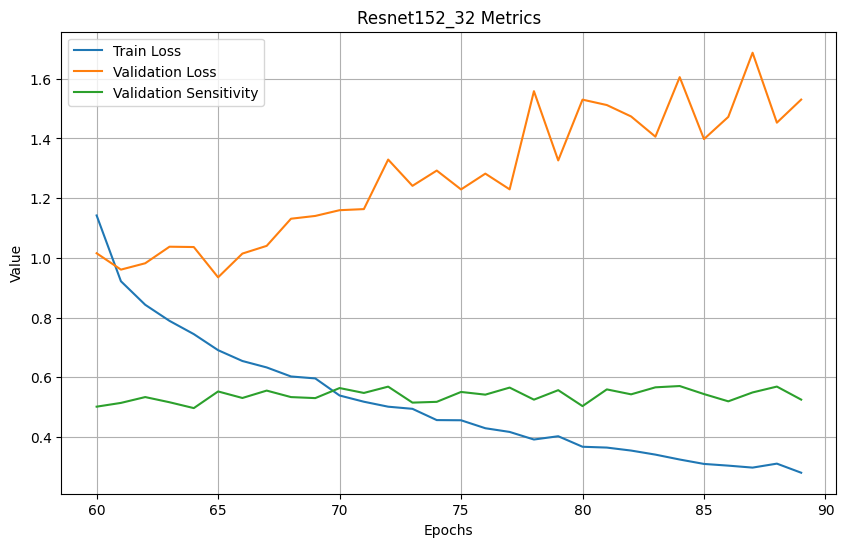

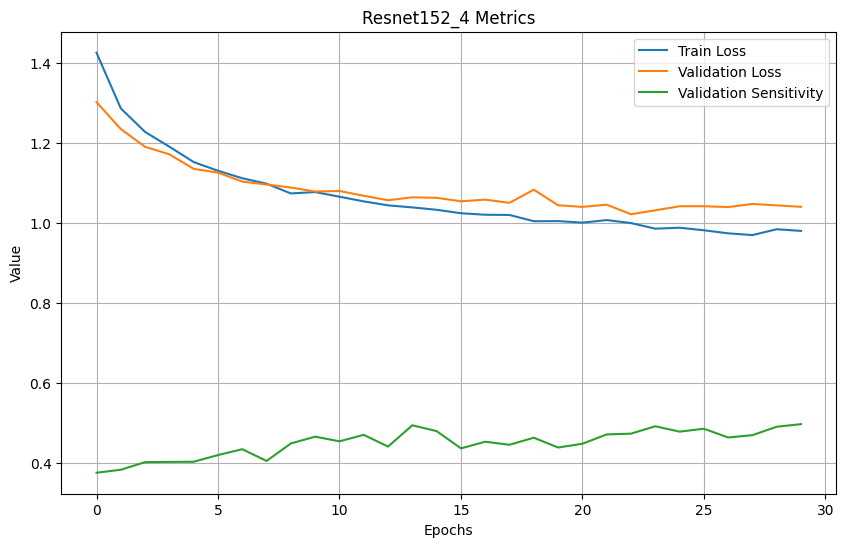

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("results/resnet152_layers.csv")
grouped_data = data.groupby('Model')

for model, model_data in grouped_data:
    plt.figure(figsize=(10, 6))
    plt.plot(model_data.index, model_data['train loss'], label='Train Loss')
    plt.plot(model_data.index, model_data['val loss'], label='Validation Loss')
    plt.plot(model_data.index, model_data['val sensitivity'], label='Validation Sensitivity')
    
    plt.title(f'{model} Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()
